<a href="https://colab.research.google.com/github/aleschiavo94/Convolutional-Neural-Network-for-Medical-Imaging-Analysis---Abnormality-detection-in-mammography/blob/main/Scratch_CNN_masses_vs_calc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1.Scratch CNN Masses and Calcifications**
---
Classification model for discriminating between 2 classes: **masses and calcification**. *Ad-hoc CNN architecture*.

**Students:**   *A. Schiavo - M. Gómez - M. Daole*

#**2.Data Preparation**

##2.1.Data Loading
This can be easily done with the Python data manipulation. Modern deep learning provides a very powerful framework for supervised learning, we introduce on this step the convolutional network for scaling to large images.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns # Grouped bar plot
import itertools
import numpy as np
import pandas as pd 
import ast #Abstract Syntax Trees
import os 
import gc # Garbage Collector

from tensorflow.keras import backend as K # Useful to free GPU and memory
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from keras import layers, optimizers, models, regularizers, metrics
from keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from imblearn.over_sampling import SMOTE

BATCH_SIZE = 20
EPOCHS = 100

METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
]

base_path = "/content/gdrive/My Drive/Colab_Notebooks/CIDL/DL Project"

MODEL_PATH = os.path.join(base_path, "models/Masses-Calcifications")
PLOTS_PATH = os.path.join(base_path, "plots/Masses-Calcifications")
RESULT_PATH = os.path.join(base_path, "results/Masses-Calcifications")

train_img_path = os.path.join(base_path, "numpy data/train_tensor.npy")
train_label_path = os.path.join(base_path, "numpy data/train_labels.npy")
test_img_path = os.path.join(base_path, "numpy data/public_test_tensor.npy")
test_label_path = os.path.join(base_path, "numpy data/public_test_labels.npy")

file_path_out = os.path.join(RESULT_PATH, "top3_results.csv")
file_path = os.path.join(RESULT_PATH, "results-CM.csv")
model_path = os.path.join(MODEL_PATH, "best_model.h5")

print("Done")

Done


In [ ]:
# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      gc.collect()

print("Done")

Done


In [ ]:
# Load Arrays from Numpy Files
def load_training():
  train_images = np.load(train_img_path)
  train_labels = np.load(train_label_path)
  test_images = np.load(test_img_path)
  test_labels = np.load(test_label_path)

  return train_images, train_labels, test_images, test_labels

def model_predictions(model, datage, dataset, labels, sample_count): 
  predictions = []

  BATCH_size = 1
  i = 0
  for batch, labels_batch in datage.flow(dataset, labels, batch_size=BATCH_size, shuffle=False):
    predictions.append(model.predict_classes(batch))
    i += 1

    if i * BATCH_size  >= sample_count:
      break
  
  return np.array(predictions)

def get_model_predictions(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=False):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

    #np.where(predictions < 0.5, 0, 1)
    #predictions = np.where(predictions < 0.5, 0, 1)

  return predictions


# Remove baseline samples
def remove_baseline(tensor): 
  max_ind = int(len(tensor)/2)
  indexes = [2*i + 1 for i in range(0, max_ind)]

  return tensor[indexes]

# Interchange the dataset index
def shuffle_dataset(x, y):
  indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
  shuffled_indices = tf.random.shuffle(indices)

  x = tf.gather(x, shuffled_indices)
  y = tf.gather(y, shuffled_indices)

  x = x.numpy()
  y = y.numpy()

  return x, y

# Unify masses and calcifications 
def labels_mapping(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  idx = 0
  for label in labels:
    # Masses
    if label == 1 or label == 2:
      labels_local[idx] = 0
    # Calcifications
    else:
      labels_local[idx] = 1
    idx += 1

  return labels_local

print("Done")

Done


In [ ]:
# Visualization Confusion Matrix
def plot_confusion_matrix(classes, # Array with the classes name
                          datagen,
                          dataset, 
                          labels,
                          batch_size=BATCH_SIZE,
                          title='Confusion matrix'):
    """
    This function prints and plots the confusion matrix.
    """
    predicted = model.predict(datagen.flow(dataset,
                                            labels,
                                            batch_size=batch_size,
                                            shuffle=False),
                          steps=len(dataset) // batch_size)

    prediction = np.where(predicted < 0.5, 0, 1)

    print('Confusion Matrix')
    cm = confusion_matrix(labels, prediction)

    print(classification_report(labels, prediction))

    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Visualization Data Histogram
def plot(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  return plt

# Visualization Detail Metric
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  plt.figure(figsize=(12,10))

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

  return plt

def plot_AUC(model, dataset, labels):
  y_pred_keras = get_model_predictions(model, dataset, labels, len(dataset))
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
  #thresholds_keras = np.linspace(0,1,num=100)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  return plt
print("Done")

Done


In [ ]:
# Get images and labels (test, train)
train_images, train_labels, test_images, test_labels = load_training()

#count quantity masses and calcifications
unique, counts = np.unique(train_labels, return_counts=True)
#print(unique, counts)

print("Benign Masses samples: \t", counts[1])
print("Malign Masses samples: \t", counts[2])
print("Benign Calc samples: \t", counts[3])
print("Malign Calc samples: \t", counts[4])

Benign Masses samples: 	 620
Malign Masses samples: 	 598
Benign Calc samples: 	 948
Malign Calc samples: 	 510


In [ ]:
# Get abnormalities only 
train_images = remove_baseline(train_images)
train_labels = remove_baseline(train_labels)
test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)

# Mapping labels with standard index
train_labels = labels_mapping(train_labels)
test_labels = labels_mapping(test_labels)

# Suffle index (Previous dataset is ordered by index)
train_images, train_labels = shuffle_dataset(train_images, train_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (2676, 150, 150)
Test shape:  (336, 150, 150)


##2.2.Data Reshape

In [ ]:
# Prepare the data with the expected format
train_images = train_images.reshape(train_images.shape + (1,))
test_images = test_images.reshape(test_images.shape + (1,))

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (2676, 150, 150, 1)
Test shape:  (336, 150, 150, 1)


In [ ]:
#check if training dataset is balanced  
unique, counts = np.unique(train_labels, return_counts=True)
print("Masses samples: ", counts[0])
print("Calcifications samples: ", counts[1])

Masses samples:  1218
Calcifications samples:  1458


In [ ]:
# Verify values range: 
# Getting max value 
max = max([np.max(image) for image in train_images]) # max is 65535 

# Getting min value
min = min([np.min(image) for image in train_images]) # min is 0

print("Original tensor are of type ", train_images[0].dtype, " with values in the range [", min,",", max, "]")

Original tensor are of type  uint16  with values in the range [ 0 , 65535 ]


##2.3.Data Normalization

Computer vision usually requires relatively little of this kind of preprocessing. The images should be standardized, formatting images to have the same scale is the only kind of preprocessing that is strictly necessary. As optional, we add dataset augmentation because is an excellent way to reduce the generalization error of most computer vision models.

In [ ]:
# All images will be rescaled by 1./65535 (max value range)
train_datagen = ImageDataGenerator(rescale=1./65535)
valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535)

##2.3.Splitting into Training and Validation data

In [ ]:
# Split dataset into training and validation set 70-30
train_images_split = train_images[:int(0.8*len(train_images))]
valid_images_split = train_images[int(0.8*len(train_images)):]
train_labels_split = train_labels[:int(0.8*len(train_labels))]
valid_labels_split = train_labels[int(0.8*len(train_labels)):]

print(train_images_split.shape)
print(valid_images_split.shape)                                       

(2140, 150, 150, 1)
(536, 150, 150, 1)


#**3.Building CNN Architecture**


##3.1.Definition CNN Model

In [ ]:
def build_model(loss, metrics=["accuracy"], optimizer=optimizers.RMSprop(lr=1e-4)):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation="relu"))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss=loss,
              optimizer=optimizer, # lr = 0.0001
              metrics=metrics) 
  
  return model 

print("Done")

Done


##3.2.Data Optimizer

In [ ]:
model = build_model("binary_crossentropy", METRICS)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [ ]:
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[GarbageCollectorCallback()])

Epoch 1/100
107/107 [==============================] - 11s 26ms/step - loss: 1.4143 - accuracy: 0.5336 - precision: 0.5480 - recall: 0.6143 - auc: 0.5088 - val_loss: 0.9915 - val_accuracy: 0.5481 - val_precision: 0.5481 - val_recall: 1.0000 - val_auc: 0.7845
Epoch 2/100
107/107 [==============================] - 2s 17ms/step - loss: 0.9147 - accuracy: 0.5872 - precision: 0.5795 - recall: 0.9444 - auc: 0.6273 - val_loss: 0.7142 - val_accuracy: 0.7385 - val_precision: 0.7052 - val_recall: 0.8982 - val_auc: 0.8506
Epoch 3/100
107/107 [==============================] - 2s 17ms/step - loss: 0.6997 - accuracy: 0.7131 - precision: 0.7198 - recall: 0.7873 - auc: 0.7714 - val_loss: 0.5712 - val_accuracy: 0.8000 - val_precision: 0.8007 - val_recall: 0.8456 - val_auc: 0.8893
Epoch 4/100
107/107 [==============================] - 2s 16ms/step - loss: 0.6088 - accuracy: 0.7725 - precision: 0.7808 - recall: 0.8119 - auc: 0.8331 - val_loss: 0.5277 - val_accuracy: 0.8231 - val_precision: 0.8784 - val_

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE,
                                     callbacks=[GarbageCollectorCallback()])
print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
print("Precision:", "%0.2f" % (test_precision*100), "%")
print("Recall:", "%0.2f" % (test_recall*100), "%")
print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 0s 9ms/step - loss: 0.6646 - acc: 0.8188 - precision: 0.8276 - recall: 0.7843 - auc: 0.8895

---------------------------------
Accuracy: 81.88 %
Precision: 82.76 %
Recall: 78.43 %
AUC: 0.89
---------------------------------



In [ ]:
## y_pred = model.predict(test_images)
## unique, counts = np.unique(test_labels, return_counts=True)
## print("Masses samples: ", counts[0])
## print("Calcifications samples: ", counts[1])
## print(unique, counts)
## 
## 
## unique, counts = np.unique(y_pred, return_counts=True)
## print("Masses samples: ", counts[0])
## print("Calcifications samples: ", counts[1])
## 
## print(unique, counts)

## predictions = get_model_predictions(model, test_images, test_labels, 336)
## unique, counts = np.unique(predictions, return_counts=True)
## print("Masses samples: ", counts[0])
## print("Calcifications samples: ", counts[1])

print(unique, counts)

predictions = model_predictions(model, test_datagen, test_images, test_labels, 336)
unique, counts = np.unique(predictions, return_counts=True)
print("Masses samples: ", counts[0])
print("Calcifications samples: ", counts[1])



[0. 1.] [ 13 323]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Masses samples:  185
Calcifications samples:  151


In [ ]:
predictions = model.predict(test_images)
print(predictions)


[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

In [ ]:
# Generate arg maxes for predictions
classes = np.argmax(predictions, axis = 1)
print(classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


In [ ]:
# Generate generalization metrics
score = model.evaluate(test_datagen.flow(test_images,
                                         test_labels,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE,
                                     callbacks=[GarbageCollectorCallback()])
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

16/16 [==============================] - 0s 8ms/step - loss: 0.6604 - acc: 0.8188 - precision: 0.8194 - recall: 0.7867 - auc: 0.8904
Test loss: 0.6603759527206421 / Test accuracy: 0.8187500238418579


In [ ]:
model = load_model(os.path.join(MODEL_PATH, 'cnn_compilation.h5'), compile = True)

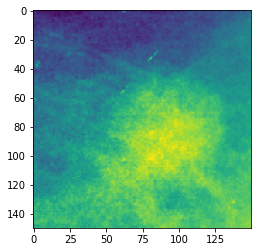

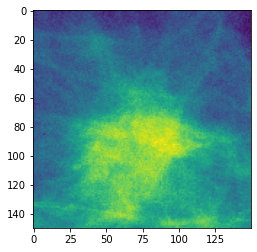

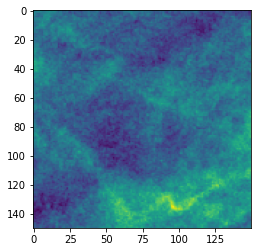

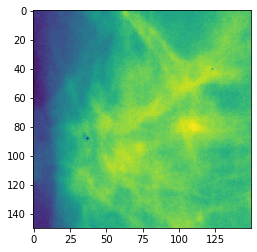

(4, 150, 150, 1)
Correct Labels [0.0, 0.0, 1.0, 0.0]
[[1.]
 [1.]
 [1.]
 [1.]]
0


In [ ]:
# A few random samples
use_samples = [45, 100, 500, 1540]
samples_to_predict = []
correct_labels = []

# Generate plots for samples
for sample in use_samples:
  # Generate a plot
  reshaped_image = train_images[sample].reshape((150, 150))
  plt.imshow(reshaped_image)
  plt.show()
  # Add sample to array for prediction
  samples_to_predict.append(train_images[sample])
  correct_labels.append(train_labels[sample])

samples_to_predict = np.array(samples_to_predict)
print(samples_to_predict.shape)
print("Correct Labels", correct_labels)

# Generate predictions for samples
predictions = model.predict(samples_to_predict)
print(predictions)

# Generate arg maxes for predictions
classes = np.argmax(predictions)
print(classes)

#5.Visualizing of the Data

One way to do this is by looking at the distribution of some of the dataset’s variables and make scatter plots to see possible correlations. 

In [ ]:
# For the visualization of the data
# Load and use the previous model
model = load_model(os.path.join(MODEL_PATH, 'cnn_compilation.h5'))

print("Done")

Done


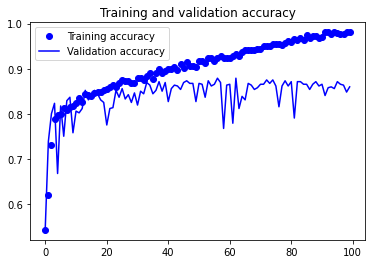

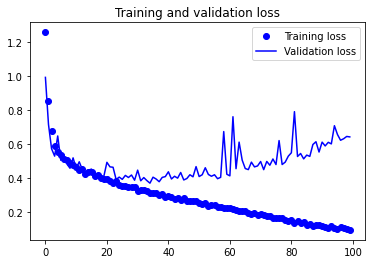

In [ ]:
plt = plot(history)
plt.show()


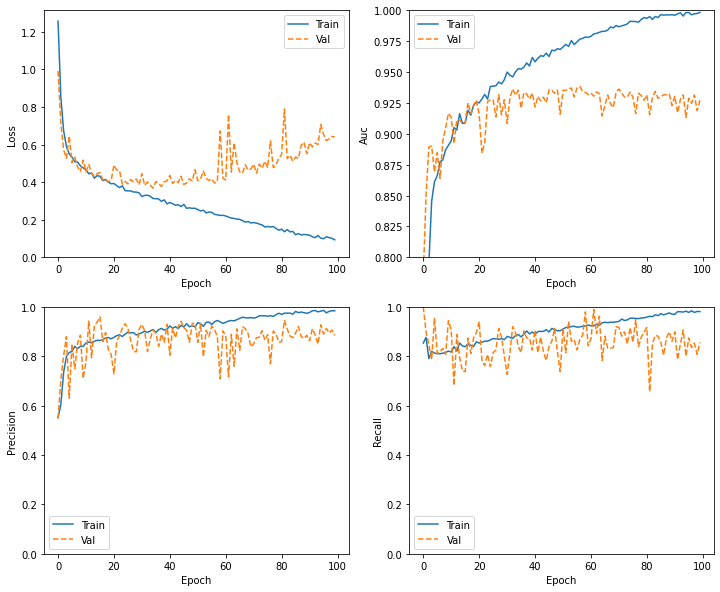

In [ ]:
plt = plot_metrics(history)
plt.show()

Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83       179
         1.0       0.81      0.78      0.80       157

    accuracy                           0.82       336
   macro avg       0.82      0.81      0.81       336
weighted avg       0.82      0.82      0.82       336



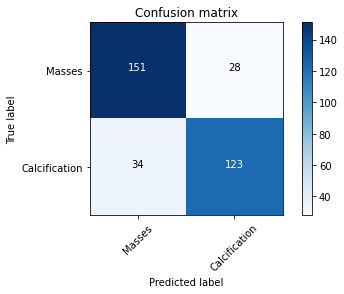

In [ ]:
# Print confusion matrix  dfsd
classes = ["Masses", "Calcification"]
batch_size = 16
plot_confusion_matrix(classes, test_datagen, test_images, test_labels, batch_size)

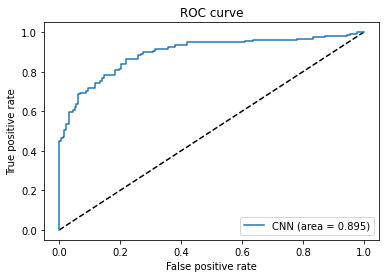

In [ ]:
# ROC-AUC 
ptl = plot_AUC(model, test_images, test_labels)
ptl.show()

(336, 150, 150, 1) (336,)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83       179
         1.0       0.81      0.78      0.80       157

    accuracy                           0.82       336
   macro avg       0.82      0.81      0.81       336
weighted avg       0.82      0.82      0.82       336

[[151  28]
 [ 34 123]]


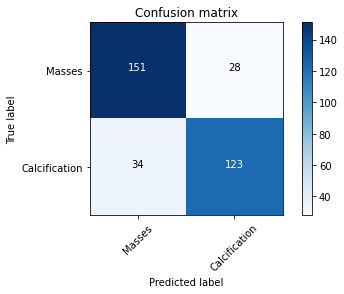

In [ ]:
# Print confusion matrix
classes = ["Masses", "Calcification"]
batch_size = 16
print(test_images.shape, test_labels.shape)
plot_confusion_matrix(classes, test_datagen, test_images, test_labels, batch_size)

#4.Fighting overfitting





##4.1.CNN Model No.1 Data Balance. UnderSampling

Masses samples:  1218
Calcifications samples:  1458


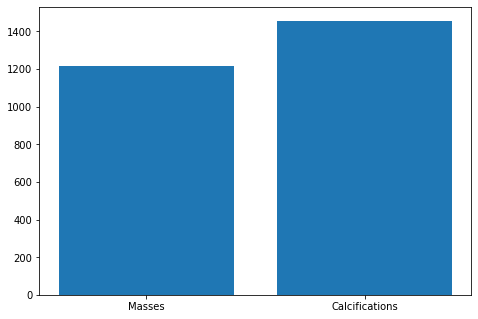

In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
print("Masses samples: ", counts[0])
print("Calcifications samples: ", counts[1])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sample = ['Masses', 'Calcifications']
count = counts
ax.bar(sample,count)
plt.show()


In [ ]:
#undersampling
def undersample(dataset, labels):
  unique, counts = np.unique(labels, return_counts=True)

  num_elems = np.min(counts)
  zipped = list(zip(dataset, labels))

  undersampled_images = []
  undersampled_labels = []

  i = 0
  label_0 = 0
  label_1 = 0
  for image, label in zipped:
    if label == 0 and label_0 < num_elems:
      undersampled_images.append(image) 
      undersampled_labels.append(label) 
      label_0 += 1 

    elif label == 1 and label_1 < num_elems:
      undersampled_images.append(image) 
      undersampled_labels.append(label) 
      label_1 += 1 


    if (label_0+label_1) == (num_elems*2):
      break

  return np.array(undersampled_images), np.array(undersampled_labels)

In [ ]:
undersampled_images, undersampled_labels = undersample(train_images, train_labels)

unique, counts = np.unique(undersampled_labels, return_counts=True)
print(unique, counts)

[0. 1.] [1218 1218]


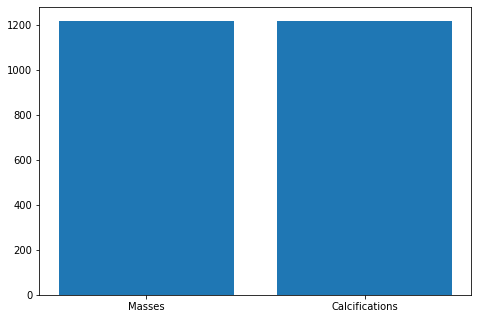

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sample = ['Masses', 'Calcifications']
count = counts
ax.bar(sample,count)
plt.show()

In [ ]:
history = model.fit(train_datagen.flow(undersampled_images,
                                       undersampled_labels,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(undersampled_labels) // BATCH_SIZE, 
                    epochs=EPOCHS)

Epoch 1/100
121/121 [==============================] - 6s 40ms/step - loss: 1.3983 - acc: 0.4981 - precision: 0.4578 - recall: 0.2899 - auc: 0.4957
Epoch 2/100
121/121 [==============================] - 5s 39ms/step - loss: 0.8928 - acc: 0.5450 - precision: 0.5502 - recall: 0.7317 - auc: 0.5032
Epoch 3/100
121/121 [==============================] - 5s 40ms/step - loss: 0.7426 - acc: 0.5175 - precision: 0.5442 - recall: 0.5003 - auc: 0.5261
Epoch 4/100
121/121 [==============================] - 5s 39ms/step - loss: 0.6960 - acc: 0.5920 - precision: 0.6137 - recall: 0.5565 - auc: 0.6336
Epoch 5/100
121/121 [==============================] - 5s 39ms/step - loss: 0.6550 - acc: 0.6608 - precision: 0.6937 - recall: 0.6525 - auc: 0.7136
Epoch 6/100
121/121 [==============================] - 5s 39ms/step - loss: 0.5998 - acc: 0.7148 - precision: 0.7277 - recall: 0.7095 - auc: 0.7824
Epoch 7/100
121/121 [==============================] - 5s 39ms/step - loss: 0.6116 - acc: 0.7115 - precision: 0.

In [ ]:
# Save Model to drive
models.save_model(model, os.path.join(MODEL_PATH, 'cnn_undersampling.h5'))

print("Done")

Done


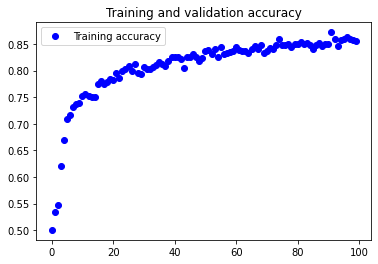

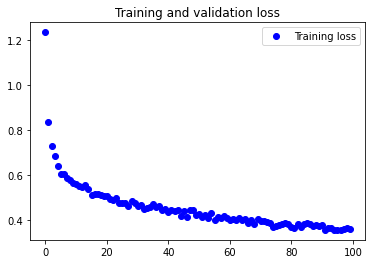

In [ ]:
plt = plot(history)
plt.show()

KeyError: ignored

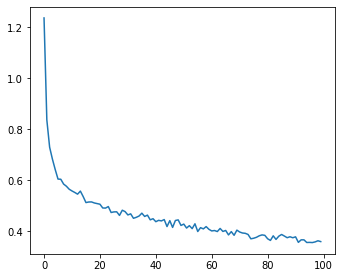

In [ ]:
plt = plot_metrics(history)
plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE,
                                     callbacks=[GarbageCollectorCallback()])
print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_acc*100), "%")
print("Precision:", "%0.2f" % (test_precision*100), "%")
print("Recall:", "%0.2f" % (test_recall*100), "%")
print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 1s 10ms/step - loss: 0.3699 - acc: 0.8500 - precision: 0.8302 - recall: 0.8627 - auc: 0.9386

---------------------------------
Accuracy: 85.00 %
Precision: 83.02 %
Recall: 86.27 %
AUC: 0.94
---------------------------------



(336, 150, 150, 1) (336,)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.88      0.85      0.86       179
         1.0       0.83      0.87      0.85       157

    accuracy                           0.86       336
   macro avg       0.86      0.86      0.86       336
weighted avg       0.86      0.86      0.86       336

[[152  27]
 [ 21 136]]


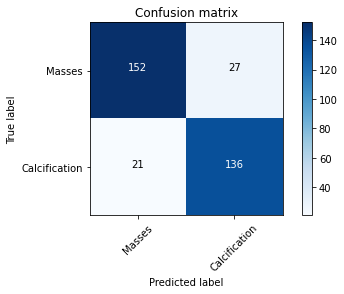

In [ ]:
# Print confusion matrix
classes = ["Masses", "Calcification"]
batch_size = 16
print(test_images.shape, test_labels.shape)
plot_confusion_matrix(classes, test_datagen, test_images, test_labels, batch_size)

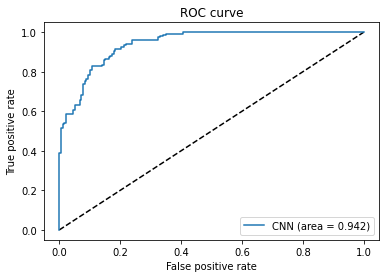

In [ ]:
# ROC-AUC 
ptl = plot_AUC(model, test_images, test_labels)
ptl.show()

##4.2.CNN Model No.1 Data Augmentation

Neural networks prove not to be very robust to noise, and these plots are characteristic of **overfitting**. Training accuracy keeps increasing linearly while validation accuracy stalls around **82%**. 

In [ ]:
# Train data augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

print("Done")

Done


In [ ]:
# Building the new model with the train data augmentation
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
]

model = build_model("binary_crossentropy", METRICS)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [ ]:
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[GarbageCollectorCallback()])

Epoch 1/100
93/93 [==============================] - 6s 48ms/step - loss: 1.4381 - acc: 0.5308 - precision: 0.5455 - recall: 0.8256 - auc: 0.4951 - val_loss: 1.0545 - val_acc: 0.5450 - val_precision: 0.5450 - val_recall: 1.0000 - val_auc: 0.6076
Epoch 2/100
93/93 [==============================] - 4s 43ms/step - loss: 0.9779 - acc: 0.5164 - precision: 0.5263 - recall: 0.8828 - auc: 0.5121 - val_loss: 0.7922 - val_acc: 0.5450 - val_precision: 0.5450 - val_recall: 1.0000 - val_auc: 0.7178
Epoch 3/100
93/93 [==============================] - 4s 43ms/step - loss: 0.7690 - acc: 0.5874 - precision: 0.5868 - recall: 0.8289 - auc: 0.6149 - val_loss: 0.6709 - val_acc: 0.6950 - val_precision: 0.6579 - val_recall: 0.9174 - val_auc: 0.7960
Epoch 4/100
93/93 [==============================] - 4s 44ms/step - loss: 0.6941 - acc: 0.6581 - precision: 0.6554 - recall: 0.8104 - auc: 0.6971 - val_loss: 0.5829 - val_acc: 0.8062 - val_precision: 0.8767 - val_recall: 0.7500 - val_auc: 0.8704
Epoch 5/100
93/9

In [ ]:
# Save Model to drive
models.save_model(model, os.path.join(MODEL_PATH, 'cnn_augmentation.h5'))

print("Done")

Done


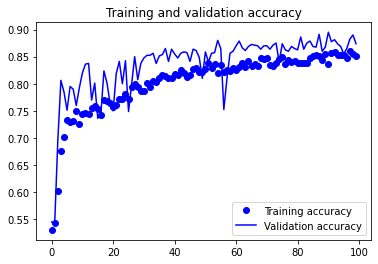

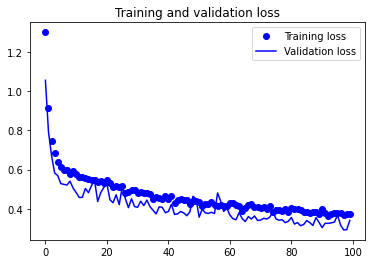

In [ ]:
plt = plot(history)
plt.show()

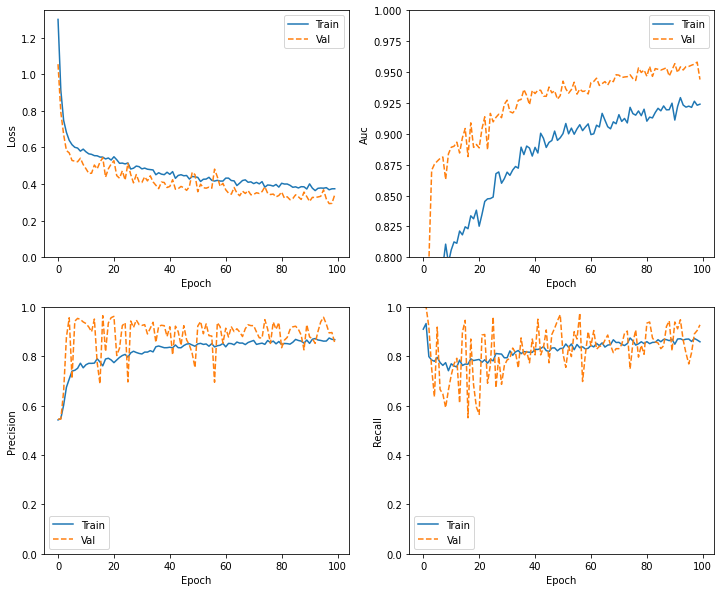

In [ ]:
plt = plot_metrics(history)
plt.show()

In [ ]:
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE,
                                     callbacks=[GarbageCollectorCallback()])
print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_acc*100), "%")
print("Precision:", "%0.2f" % (test_precision*100), "%")
print("Recall:", "%0.2f" % (test_recall*100), "%")
print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")

16/16 [==============================] - 0s 9ms/step - loss: 0.3751 - acc: 0.8406 - precision: 0.7964 - recall: 0.8867 - auc: 0.9337

---------------------------------
Accuracy: 84.06 %
Precision: 79.64 %
Recall: 88.67 %
AUC: 0.93
---------------------------------



(336, 150, 150, 1) (336,)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.89      0.80      0.84       179
         1.0       0.80      0.89      0.84       157

    accuracy                           0.84       336
   macro avg       0.84      0.84      0.84       336
weighted avg       0.85      0.84      0.84       336

[[144  35]
 [ 18 139]]


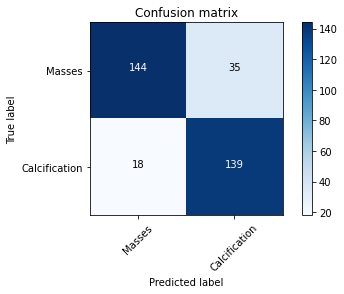

In [ ]:
# Print confusion matrix
classes = ["Masses", "Calcification"]
batch_size = 16
print(test_images.shape, test_labels.shape)
plot_confusion_matrix(classes, test_datagen, test_images, test_labels, batch_size)

In [ ]:
# ROC-AUC 
ptl = plot_AUC(model, test_images, test_labels)
ptl.show()

##4.3.CNN Model No.2 K-fold cross validation.


In [ ]:
# Train data augmentation for k-fold-cross-validation 
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)
print(train_images.shape)

(2676, 150, 150, 1)


In [ ]:
def cross_validate(k, batch_size, num_epochs, dataset, targets, verbosity):
  #10-Fold-Cross-Validation
  num_val_samples = len(dataset) // k 
  validation_accuracies = []
  validation_losses = []

  for i in range(k):
    # rigen augmented data 
    
    print("processing fold #", i)
    validation_data = dataset[i * num_val_samples : (i + 1) * num_val_samples]
    validation_labels = targets[i * num_val_samples : (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [dataset[:i * num_val_samples],
        dataset[(i + 1) * num_val_samples:]], 
        axis=0)

    partial_train_targets = np.concatenate(
        [targets[:i * num_val_samples],
        targets[(i + 1) * num_val_samples:]], 
        axis=0)

    model = build_model("binary_crossentropy", METRICS)
    
    history = model.fit(train_datagen.flow(partial_train_data, 
                                          partial_train_targets,
                                          batch_size=batch_size,
                                          shuffle=False),
                        epochs=num_epochs,
                        steps_per_epoch=len(partial_train_data) // batch_size,
                        verbose=verbosity,
                        callbacks=[GarbageCollectorCallback()])
    
    val_loss, val_acc = model.evaluate(valid_datagen.flow(validation_data,
                                                          validation_labels,
                                                          batch_size=batch_size,
                                                          shuffle=False),
                                       steps=len(validation_data) // batch_size,
                                       callbacks=[GarbageCollectorCallback()])
    
    validation_accuracies.append(val_acc)
    validation_losses.append(val_loss)

  return validation_accuracies, validation_losses 
  
print("Done")

Done


In [ ]:
acc, loss = cross_validate(k=10, batch_size=20, num_epochs=100, dataset=train_images, targets=train_labels, verbosity=1)

processing fold # 0
Epoch 1/100
120/120 [==============================] - 6s 42ms/step - loss: 1.3859 - accuracy: 0.5277
Epoch 2/100
120/120 [==============================] - 5s 42ms/step - loss: 0.8745 - accuracy: 0.5527
Epoch 3/100
120/120 [==============================] - 5s 42ms/step - loss: 0.7104 - accuracy: 0.6099
Epoch 4/100
120/120 [==============================] - 5s 42ms/step - loss: 0.6543 - accuracy: 0.6783
Epoch 5/100
120/120 [==============================] - 5s 42ms/step - loss: 0.6081 - accuracy: 0.7210
Epoch 6/100
120/120 [==============================] - 5s 42ms/step - loss: 0.5829 - accuracy: 0.7293
Epoch 7/100
120/120 [==============================] - 5s 41ms/step - loss: 0.5783 - accuracy: 0.7536
Epoch 8/100
120/120 [==============================] - 5s 42ms/step - loss: 0.6076 - accuracy: 0.7143
Epoch 9/100
120/120 [==============================] - 5s 41ms/step - loss: 0.5694 - accuracy: 0.7356
Epoch 10/100
120/120 [==============================] - 5s 42m

In [ ]:
# Save Model to drive
models.save_model(model, os.path.join(MODEL_PATH, 'cnn_cross_validation.h5'))

print("Done")

Done


In [ ]:
model = load_model(os.path.join(MODEL_PATH, 'cnn_cross_validation.h5'), compile = True)

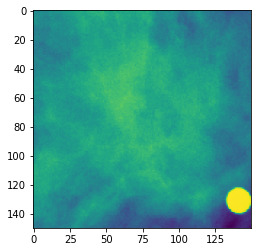

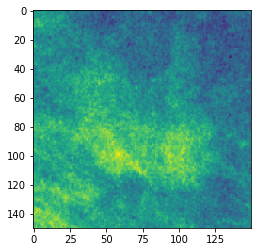

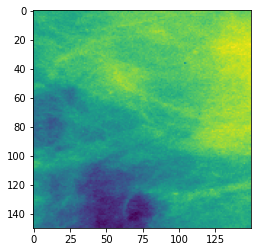

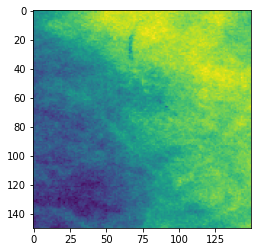

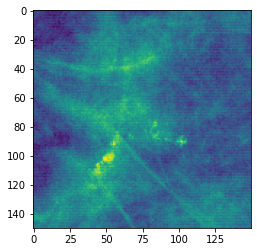

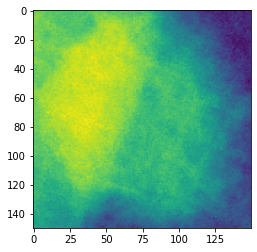

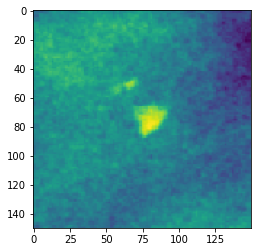

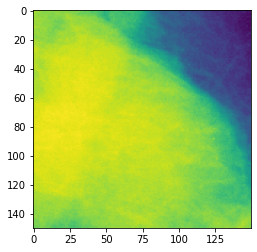

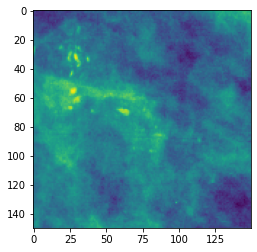

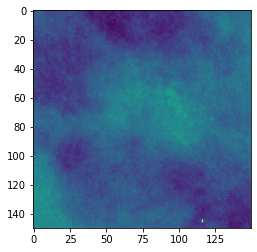

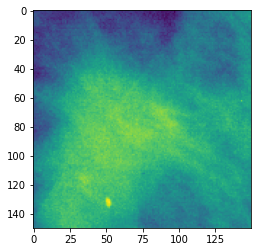

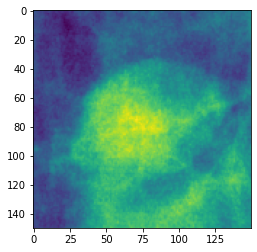

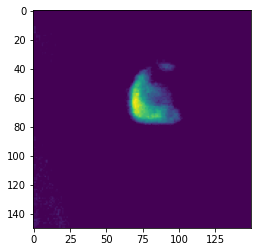

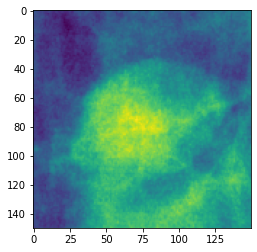

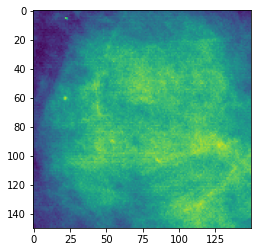

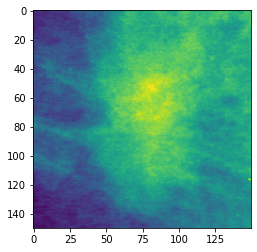

(16, 150, 150, 1)
Correct Labels [0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# A few random samples
use_samples = [5,6,7,8,9, 1200, 400, 140, 425, 180, 200, 10, 495, 10, 50, 154]
samples_to_predict = []
correct_labels = []

# Generate plots for samples
for sample in use_samples:
  # Generate a plot
  reshaped_image = train_images[sample].reshape((150, 150))
  plt.imshow(reshaped_image)
  plt.show()
  # Add sample to array for prediction
  samples_to_predict.append(train_images[sample])
  correct_labels.append(train_labels[sample])

samples_to_predict = np.array(samples_to_predict)
print(samples_to_predict.shape)
print("Correct Labels", correct_labels)

# Generate predictions for samples
predictions = model.predict(samples_to_predict)
print(predictions)

# Generate arg maxes for predictions
classes = np.argmax(predictions, axis=1)
print(classes)

#5.Hyperparameters Tuning

To compare the performance of one machine learning algorithm to another, it is necessary to perform controlled experiments


In [ ]:
# Add Dropout or L2 Regularization
# Varying of convolutional layers: [3, 5, 7]
# Change Optimizer (try Adam)
# Varying batch size: [32,64,128,128] and [64,64,128,256]
# Varying learning rate
# Varying number of units per layer:

#Parameters Grid 
dropout_regularization = True # grafico comparativo: sembra leggermente meglio con Dropout                                              
batch_sizes = [20, 32, 64, 128]                                           
layers_number = 4                                                         
units_per_layer_dict = [[32,64,128,128], [32,64,128,256]]                 
learning_rates = [1e-2, 1e-3, 1e-4]                                       
num_epochs = 100
num_folds = 5

# Top k models 
k = 3

In [ ]:
def build_custom_model(layers_number, units_per_layer, batch_size, dropout, optimizer):
  model = models.Sequential()

  for i in range(layers_number):
     # First layer. Setting input shape
    if i == 0: 
      model.add(layers.Conv2D(units_per_layer[i], (3, 3), activation='relu', input_shape=(150, 150, 1)))
      model.add(layers.MaxPooling2D((2, 2)))
    else:
      model.add(layers.Conv2D(units_per_layer[i], (3, 3), activation='relu'))
      model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  
  if dropout:
    model.add(layers.Dropout(0.5))

  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"]) 
  
  return model 

def CNN_tuning(num_folds, batch_sizes, num_epochs, layers_number, units_per_layer_dict, learning_rates, dropout_reg, dataset, targets):
  counter = 0
  lr = learning_rates[0]
  opts = [optimizers.RMSprop(learning_rate=lr), optimizers.Adam(learning_rate=lr)]

  with open(file_path, 'w') as f:
    header = "name,batch_size,num_epochs,units_per_layer,optimizer,learning_rate,mean_val_acc,std,mean_val_loss,std_loss,num_folds\n"
    f.write(header)

  for batch_size in batch_sizes:                # 4
    for opt in opts:                            # 2
      for values_set in units_per_layer_dict:   # 2
        # Build CNN model 
        model = build_custom_model(layers_number, values_set, batch_size, dropout_reg, opt)

        if "RMSprop" in str(opt):
          str_opt = "RMSprop"  
        else:
          str_opt = "Adam"

        #print info 
        print("-----------------------------------------------------")
        print("batch_size: \t", batch_size)
        print("num_epochs: \t", num_epochs)
        print("units_per_layer:", str(values_set).replace(",", " "))
        print("optimizer: \t", str_opt)
        print("learning_rate: \t", str(lr))
        print("num_folds CV: \t", num_folds)
        print("-----------------------------------------------------")

        #cross validate CNN model
        val_acc, val_loss = cross_validate(num_folds, batch_size, num_epochs, dataset, targets, 1)

        #save results on csv file 
        counter +=1 
        with open(file_path, 'a') as f:
          row = "Name_%3.0f" % counter + "," \
              + str(batch_size) + "," \
              + str(num_epochs) + "," \
              + str(values_set).replace(",", " ") + "," \
              + str_opt + "," \
              + str(lr) + "," \
              + "%0.4f" % (np.mean(val_acc)) + "," \
              + "(+/- %0.4f)" % (np.std(val_acc) * 2) + "," \
              + "%0.4f" % (np.mean(val_loss)) + "," \
              + "(+/- %0.4f)" % (np.std(val_loss) * 2) + "," \
              + str(num_folds) + "\n"
          f.write(row)

        del model
        K.clear_session()

print("Done")

Done


In [ ]:
CNN_tuning(num_folds, batch_sizes, num_epochs, layers_number, units_per_layer_dict, learning_rates, dropout_regularization, train_images, train_labels)

#6.Testing best 3 models
feeding the models with all available data and evaluating these one last time on the test set.

In [ ]:
def evaluate_best_model(k, file_path, file_path_out):
  counter = 0
  # Load results  
  data = pd.read_csv(file_path)

  # Sort results by accuracies 
  data.sort_values(by=['mean_val_acc'], ascending=False, inplace=True)
  data.head()

  # Init variables
  layers_number = 4
  batch_size = 0
  num_epochs = 0
  units_per_layer = []
  optimizer = 0
  learning_rate = 0
  dropout=True

  with open(file_path_out, 'w') as f:
    header = "name,batch_size,num_epochs,units_per_layer,optimizer,learning_rate,mean_val_acc,mean_val_loss,prediction_acc\n"
    f.write(header)

  # Get parameters values
  for index, row in data[:k].iterrows():

    #print info 
    print("-----------------------------------------------------")
    print("batch_size: \t", str(row["batch_size"]))
    print("num_epochs: \t", str(row["num_epochs"]))
    print("units_per_layer:", str(row["units_per_layer"]))
    print("optimizer: \t", str(row["optimizer"]))
    print("learning_rate: \t", str(row["learning_rate"]))
    print("mean_val_acc: \t", str(row["mean_val_acc"]))
    print("mean_val_loss: \t", str(row["mean_val_loss"]))
    print("-----------------------------------------------------")


    batch_size = int(row["batch_size"])
    num_epochs = int(row["num_epochs"])
    units_per_layer = ast.literal_eval(row["units_per_layer"].replace("  ", ","))
    optimizer = row["optimizer"]
    learning_rate = row["learning_rate"]

    if optimizer == "Adam":
      opt = optimizers.Adam(learning_rate=float(learning_rate))
    else: 
      opt = optimizers.RMSprop(learning_rate=float(learning_rate))

    # Build model
    ## model = build_custom_model(layers_number, units_per_layer, batch_size, dropout, opt)
    model = build_model("binary_crossentropy")

    # Fit model on all the available data
    history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[GarbageCollectorCallback()])
    
    # Evaluate model on test set 
    test_loss, test_acc = model.evaluate(test_datagen.flow(test_images,
                                                        test_labels,
                                                        batch_size=batch_size,
                                                        shuffle=False),
                                        steps=len(test_images) // batch_size,
                                        callbacks=[GarbageCollectorCallback()])

    print("Accuracy:", "%0.2f" % (test_acc*100), "%")

    # Get the prediction for each sample
    predictions = model.predict(
      test_images,
      max_queue_size=10,
      callbacks=[GarbageCollectorCallback()]) 
    
    predicted = np.argmax(predictions,axis=1) 

    correct_predictions = np.sum(np.equal(predicted,test_labels))
    accuracy = correct_predictions/len(test_labels)
    print("\n-----------------------------------------------------")
    print("Correct Predictions")
    print("Accuracy:", "%0.2f" % (accuracy*100), "%")
    print("-----------------------------------------------------\n")

    if index == 0:
      model.save(model_path)

    # Save results on csv file 
    counter +=1 
    with open(file_path_out, 'a') as f:
      row = "Name_%3.0f" % counter + "," \
          + str(row["batch_size"]) + "," \
          + str(row["num_epochs"]) + "," \
          + str(row["units_per_layer"]) + "," \
          + str(row["optimizer"]) + "," \
          + str(row["learning_rate"]) + "," \
          + "%0.4f" % (test_acc) + "," \
          + "%0.4f" % (test_loss) + "," \
          + str(accuracy) + "\n"
      f.write(row)

print("Done")

Done


In [ ]:
k = 1
# Get from file the a list of models and evaluate the best
evaluate_best_model(k, file_path, file_path_out)

-----------------------------------------------------
batch_size: 	 20
num_epochs: 	 100
units_per_layer: [32  64  128  256]
optimizer: 	 RMSprop
learning_rate: 	 0.01
mean_val_acc: 	 0.8865
mean_val_loss: 	 0.3096
-----------------------------------------------------
Epoch 1/100
93/93 [==============================] - 5s 45ms/step - loss: 1.4301 - accuracy: 0.5172 - val_loss: 1.0323 - val_accuracy: 0.5575
Epoch 2/100
93/93 [==============================] - 4s 43ms/step - loss: 0.9583 - accuracy: 0.5448 - val_loss: 0.7864 - val_accuracy: 0.5575
Epoch 3/100
93/93 [==============================] - 4s 42ms/step - loss: 0.7656 - accuracy: 0.5867 - val_loss: 0.7036 - val_accuracy: 0.6925
Epoch 4/100
93/93 [==============================] - 4s 42ms/step - loss: 0.7110 - accuracy: 0.6193 - val_loss: 0.6547 - val_accuracy: 0.7375
Epoch 5/100
93/93 [==============================] - 4s 44ms/step - loss: 0.6643 - accuracy: 0.6619 - val_loss: 0.6178 - val_accuracy: 0.6225
Epoch 6/100
93/93 [==

In [ ]:
# Evaluate model on test set 
test_loss, test_acc = model.evaluate(test_datagen.flow(test_images,
                                                    test_labels,
                                                    batch_size=batch_size,
                                                    shuffle=False),
                                    steps=len(test_images) // batch_size,
                                    callbacks=[GarbageCollectorCallback()])

21/21 [==============================] - 0s 9ms/step - loss: 0.3669 - acc: 0.8571 - precision: 0.8344 - recall: 0.8662 - auc: 0.9416


ValueError: ignored

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [ ]:
# Get the prediction for each sample
model = load_model(model_path)


In [ ]:

predictions = model.predict(
  test_images,
  max_queue_size=10,
  callbacks=[GarbageCollectorCallback()]) 

predicted = np.argmax(predictions,axis=1) 

correct_predictions = np.sum(np.equal(predicted,test_labels))
accuracy = correct_predictions/len(test_labels)


# try to load the model again

test_loss, test_acc = model.evaluate(test_images,test_labels)

print('test_acc:', test_acc)

In [ ]:
#print confusion matrix
classes = ["Masses", "Calcification"]
plot_confusion_matrix(classes,
                      test_datagen,
                      test_images,
                      test_labels) 

#7.Choose the Best Model

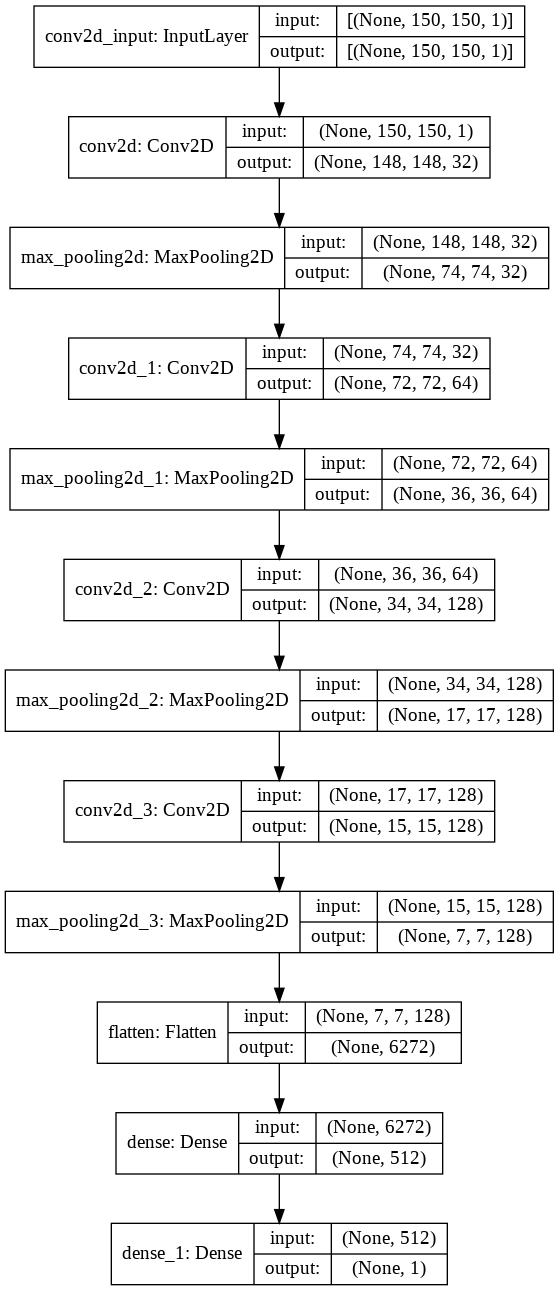

In [ ]:
plot_model(model, to_file=os.path.join(MODEL_PATH,'BestModel.png'), show_shapes=True)

#

# Reference


>**Student** | **Email contact**
>--- | ---
>A. Schiavo | a.schiavo2@studenti.unipi.it
>M. Gómez	|	m.gomezgomez@studenti.unipi.it
>M. Daole |	m.daole@studenti.unipi.it
